# Задание к занятию «Методы декомпозиции»

Преподаватель: Егор Сачко
Описание задания:

Что сделать

Обязательные

1. Провести первичный анализ данных

Посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи.

2. На большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов.

3. На фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в sklearn.decomposition.pca.components_ после построения главных компонент).

4. С отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. 

Метрика оценки качества — ROC AUC.

 

Дополнительные

Поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого используйте все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.

 

Формат сдачи

Ноутбук с кодом/картинками выполненной обязательной части + указание места в leaderboard при решении дополнительной.

 

Дополнительная информация по заданию

Ноубук на Гитхабе.

## Обработка данных

При подготовке признаков будем использовать дополнительные данные:
- справочник MMC кодов https://mcc-codes.ru/ , который позволит получить категории
- курсы валют http://export.rbc.ru/expdocs/free.cb.0.shtml, что позволит перевести валютные операции в рубли, для дальнейшего агрегирования
- ISO справочник валют нужен для объединения исходных данных и курсов валют (https://www.currency-iso.org/en/home/tables/table-a1.html)

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [108]:
df_train = pd.read_csv('train.csv', dtype={'currency': object, 'MCC': object})
df_test = pd.read_csv('test.csv', dtype={'currency': object, 'MCC': object})
mcc_codes = pd.read_csv('mcc-codes.csv', dtype={'MCC': object })
iso_codes = pd.read_csv('iso_codes.csv', dtype={'Numeric Code': object })
curr_rates = pd.read_csv('curr_rates.csv', dtype={'Numeric Code': object })

In [109]:
y = df_train[['cl_id','target_flag']]
df_train.drop(['target_flag', 'target_sum'], axis=1, inplace=True)
y = y.drop_duplicates()
y = y.set_index('cl_id')
y.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [110]:
y['target_flag'].value_counts()

1    2767
0    2233
Name: target_flag, dtype: int64

Категории более менее сбалансированы, но на кросс валидации будем делать стратифицированное разбиение обучающего набора

In [111]:
df_train['is_test'] = 0
df_test['is_test'] = 1
df_train.shape, df_test.shape, y.shape

((490513, 9), (518376, 9), (5000, 1))

Готовить новые признаки и агреггировать будем сразу для обоих наборов данных

In [112]:
df = pd.concat([df_train, df_test])
df.shape

(1008889, 9)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 518375
Data columns (total 9 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1003825 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 77.0+ MB


В channel_type есть пустые значения. Возможно, один из видов каналов привлечения клиентов просто не заполнен. Заполним пустые значения channel_type константой, которую модель будет трактовать как отдельный канал привлечения

In [114]:
df['channel_type'].value_counts()

type1    619756
type2    357071
type5      9668
type4      9485
type3      7845
Name: channel_type, dtype: int64

In [115]:
df['channel_type'].fillna('NaN', inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 518375
Data columns (total 9 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 77.0+ MB


In [117]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


### Категории MMC

Добавим категории MCC кодов

In [118]:
mcc_codes = mcc_codes[['MCC', 'MCC_group']]
mcc_codes['MCC_group'].value_counts()

Отели и мотели                      304
Авиалинии_авиакомпании              289
Арендаавтомобилей                    92
Различныемагазины                    53
Поставщик услуг                      33
Оптовыепоставщики ипроизводители     31
Бизнес услуги                        25
Развлечения                          22
Розничныемагазины                    21
Профессиональныеуслуги               20
Транспорт                            18
Личные услуги                        17
Ремонтные услуги                     13
Автомобили итранспортныесредства     13
Магазины одежды                      12
Контрактныеуслуги                    11
Государственныеуслуги                11
Продажи по почте/телефону             9
Коммунальные икабельные услуги        8
Членскиеорганизации                   6
Name: MCC_group, dtype: int64

In [119]:
df['MCC'].str.len().value_counts()

4    1008682
3        207
Name: MCC, dtype: int64

In [120]:
mcc_codes['MCC'].str.len().value_counts()

4    1019
Name: MCC, dtype: int64

Перед объединением, трехзначные MCC коды дополним нулем до четырех знаков

In [121]:
df['MCC'] = df['MCC'].str.pad(4, side='left', fillchar='0')

In [122]:
df['MCC'].str.len().value_counts()

4    1008889
Name: MCC, dtype: int64

In [123]:
df = pd.merge(df, mcc_codes, how='left', on='MCC')

In [124]:
df.sample(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group
541019,01/12/2016,935,4829,type2,810,12DEC16:17:59:33,5000.00,C2C_OUT,1,Поставщик услуг
386005,01/06/2017,7803,6011,type1,810,05JUN17:10:58:21,800.00,WD_ATM_ROS,0,Поставщик услуг
824091,01/01/2017,6091,4829,type1,810,19JAN17:19:47:34,5949.42,C2C_OUT,1,Поставщик услуг
70145,01/05/2017,1262,5311,type2,810,02MAY17:00:00:00,1592.17,POS,0,Розничныемагазины
72999,01/05/2017,1317,5411,type2,810,20MAY17:00:00:00,148.50,POS,0,Розничныемагазины
874775,01/01/2017,7237,5814,type1,810,05JAN17:00:00:00,167.00,POS,1,Различныемагазины
908533,01/03/2017,7873,6011,type1,810,20MAR17:07:24:21,60000.00,DEPOSIT,1,Поставщик услуг
538769,01/03/2017,881,5411,type2,810,22MAR17:00:00:00,199.00,POS,1,Розничныемагазины
160469,01/11/2016,2838,4112,type2,810,23NOV16:00:00:00,2188.00,POS,0,Транспорт
194786,01/06/2017,3430,5814,type1,810,21JUN17:00:00:00,228.00,POS,0,Различныемагазины


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 10 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008887 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 84.7+ MB


Пустые значения MCC_group заполним константой

In [126]:
df['MCC_group'].fillna('Nan', inplace=True)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 10 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008889 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 84.7+ MB


### Курсы валют

Видно, что большинство транзакций не содержат данных о времени проведения операции. Поэтому нет смысла добавлять признаки, связанные с времененем операции. А жаль, можно было бы агрегировать транзакции по времени суток..

In [128]:
df[df['TRDATETIME'].str.contains(':00:00:00') ].shape

(890639, 10)

In [129]:
df['TRDATETIME'] =  pd.to_datetime(df['TRDATETIME'], format='%d%b%y:%H:%M:%S')
df['PERIOD'] =  pd.to_datetime(df['PERIOD'], format='%d/%m/%Y')
df['PERIOD'] = df['PERIOD'].dt.to_period('M')
#df['TRDATETIME'] = df['TRDATETIME'].dt.date

In [130]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group
0,2017-10,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,Розничныемагазины
1,2017-10,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,Поставщик услуг
2,2017-12,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,Различныемагазины
3,2017-10,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,Розничныемагазины
4,2017-10,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,Поставщик услуг


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 10 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null datetime64[ns]
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008889 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 84.7+ MB


Большинство операций в рублях. Для дальнейшего агреггирования по суммам операций добавим курс валюты на день операции (или ближайшего рабочего дня) и добавим новую колонку с суммой валютной операции в рублях.

In [132]:
df['currency'].value_counts().head(10)

810    981731
978     11573
840      3808
933      1460
764       941
203       924
949       902
985       749
826       705
975       596
Name: currency, dtype: int64

In [133]:
df['currency'] = df['currency'].str.pad(3, side='left', fillchar='0')

In [134]:
iso_codes = iso_codes.drop_duplicates()
iso_codes.head()

,Alphabetic Code,Numeric Code
0,AFN,971
1,EUR,978
2,ALL,008
3,DZD,012
4,USD,840


In [135]:
curr_rates = curr_rates[['TICKER','DATE','CLOSE','NOMINAL']]
curr_rates['DATE'] = pd.to_datetime(curr_rates['DATE'])
#curr_rates['DATE'] = curr_rates['DATE'].dt.date
curr_rates.head()

,TICKER,DATE,CLOSE,NOMINAL
0,AMD,2016-10-07,13.1624,100
1,AUD,2016-10-07,47.3852,1
2,AZN,2016-10-07,38.6172,1
3,BGN,2016-10-07,35.7208,1
4,BRL,2016-10-07,19.3728,1


In [136]:
df = pd.merge(df, iso_codes, how='left', left_on='currency', right_on='Numeric Code')
df.drop('Numeric Code', axis=1, inplace=True)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 11 columns):
PERIOD             1008889 non-null object
cl_id              1008889 non-null int64
MCC                1008889 non-null object
channel_type       1008889 non-null object
currency           1008889 non-null object
TRDATETIME         1008889 non-null datetime64[ns]
amount             1008889 non-null float64
trx_category       1008889 non-null object
is_test            1008889 non-null int64
MCC_group          1008889 non-null object
Alphabetic Code    1008836 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 92.4+ MB


In [138]:
df.rename(columns={'Alphabetic Code': 'curr_code'}, inplace=True)
df.sample(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code
10299,2017-06,206,4121,type4,702,2017-06-11 00:00:00,28.45,POS,0,Транспорт,SGD
464588,2017-01,9658,5912,type1,810,2017-01-10 00:00:00,484.00,POS,0,Различныемагазины,RUB
510471,2017-04,445,5411,type2,810,2017-04-01 00:00:00,125.00,POS,1,Розничныемагазины,RUB
598464,2017-08,1817,5411,type2,810,2017-08-30 00:00:00,398.00,POS,1,Розничныемагазины,RUB
349934,2016-12,7007,5921,type1,810,2016-12-31 00:00:00,653.90,POS,0,Различныемагазины,RUB
421693,2017-06,8646,5541,type1,810,2017-06-29 00:00:00,999.69,POS,0,Автомобили итранспортныесредства,RUB
38734,2017-05,695,5411,type2,810,2017-05-17 00:00:00,138.32,POS,0,Розничныемагазины,RUB
848168,2017-05,6643,5211,type1,810,2017-05-23 00:00:00,927.20,POS,1,Розничныемагазины,RUB
419347,2016-12,8590,5732,type1,810,2016-12-06 00:00:00,625.00,POS,0,Различныемагазины,RUB
794143,2017-03,5540,6011,type1,810,2017-03-14 18:02:36,150000.00,WD_ATM_ROS,1,Поставщик услуг,RUB


In [139]:
curr_rates.rename(columns={'TICKER': 'curr_code', 'DATE': 'TRDATETIME', 'CLOSE': 'exch_rate', 'NOMINAL': 'exch_nominal'}, inplace=True)
curr_rates.head()

,curr_code,TRDATETIME,exch_rate,exch_nominal
0,AMD,2016-10-07,13.1624,100
1,AUD,2016-10-07,47.3852,1
2,AZN,2016-10-07,38.6172,1
3,BGN,2016-10-07,35.7208,1
4,BRL,2016-10-07,19.3728,1


In [140]:
df = pd.merge_asof(df.sort_values(by=['TRDATETIME']), curr_rates.sort_values(by=['TRDATETIME']), on='TRDATETIME', by='curr_code', tolerance=pd.Timedelta('10d'))
df.loc[df['currency'] == '810', 'exch_rate'] = 1
df.loc[df['currency'] == '810', 'exch_nominal'] = 1


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 13 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null datetime64[ns]
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008889 non-null object
curr_code       1008836 non-null object
exch_rate       1005519 non-null float64
exch_nominal    1005519 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 107.8+ MB


Для валюты у трех тысяч операций не нашлось курса. При агрегировании в рублях будем считать эти операции нулевыми. Можно было бы заморочиться дальше и использовать дополнительные кросс курсы в евро или долларах.

In [142]:
df['exch_rate'].fillna(0, inplace=True)
df['exch_nominal'].fillna(1, inplace=True)

In [143]:
df['amount_rub'] = df['amount'] / df['exch_nominal'] * df['exch_rate']

In [144]:
df[df['currency'] != '810'].sample(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub
975917,2017-11,2761,6011,type2,156,2017-11-07,1000.00,WD_ATM_OTHER,1,Поставщик услуг,CNY,88.1451,10.0,8814.51000
106828,2016-12,10113,5999,type1,840,2016-12-21,65.00,POS,0,Различныемагазины,USD,61.7967,1.0,4016.78550
660920,2017-06,4734,5722,type1,978,2017-06-24,21.97,POS,1,Различныемагазины,EUR,66.6780,1.0,1464.91566
779397,2017-07,9082,5411,type1,404,2017-07-26,2008.00,POS,1,Розничныемагазины,KES,0.0000,1.0,0.00000
817515,2017-08,3426,6011,type1,978,2017-08-05,200.00,WD_ATM_OTHER,1,Поставщик услуг,EUR,71.6879,1.0,14337.58000
894709,2017-09,425,5812,type2,949,2017-09-01,6.00,POS,1,Различныемагазины,TRY,16.9128,1.0,101.47680
229796,2017-01,9499,5691,type1,348,2017-01-27,17800.00,POS,1,Магазины одежды,HUF,20.6377,100.0,3673.51060
670573,2017-06,6198,7996,type1,978,2017-06-26,24.89,POS,0,Развлечения,EUR,66.6780,1.0,1659.61542
880770,2017-08,5070,5311,type1,978,2017-08-26,301.00,POS,0,Розничныемагазины,EUR,69.6995,1.0,20979.54950
293363,2017-02,8787,4814,type1,484,2017-02-19,58.00,POS,0,Коммунальные икабельные услуги,MXN,0.0000,1.0,0.00000


### Дни недели и выходные

По времени транзакции вычисляем и добавляем день недели и признак того, что это выходной день

In [145]:
df['dayofweek'] = df['TRDATETIME'].dt.dayofweek.astype('object')
df['is_weekend'] = (df['dayofweek'] >= 5).astype('int64')

In [146]:
df.sample(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend
432411,2017-04,4940,5541,type1,810,2017-04-15 00:00:00,1534.00,POS,0,Автомобили итранспортныесредства,RUB,1.0,1.0,1534.00,5,1
971460,2017-10,158,5411,type4,810,2017-10-27 00:00:00,6498.00,POS,1,Розничныемагазины,RUB,1.0,1.0,6498.00,4,0
591716,2017-06,4980,5999,type1,810,2017-06-04 23:00:39,800.00,POS,0,Различныемагазины,RUB,1.0,1.0,800.00,6,1
214936,2017-01,3281,5499,type2,810,2017-01-22 00:00:00,977.87,POS,0,Розничныемагазины,RUB,1.0,1.0,977.87,6,1
213301,2017-01,4459,5541,type1,810,2017-01-21 00:00:00,969.00,POS,1,Автомобили итранспортныесредства,RUB,1.0,1.0,969.00,5,1


### Пополнение баланса

Далее, по категориям транзакций добавляем признак пополнения баланса

In [147]:
in_category = ['C2C_IN', 'DEPOSIT']
out_category = ['POS', ' C2C_OUT', 'WD_ATM_PARTNER']

In [148]:
#df['in'] = df['trx_category'].isin(in_category).astype('object')
df['is_withdrawal'] = df['trx_category'].isin(out_category).astype('object')

In [149]:
df.sample(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend,is_withdrawal
535980,2017-05,1959,5411,type2,810,2017-05-19,157.00,POS,0,Розничныемагазины,RUB,1.0,1.0,157.00,4,0,True
477595,2017-04,8396,5921,type1,810,2017-04-30,992.00,POS,0,Различныемагазины,RUB,1.0,1.0,992.00,6,1,True
300430,2017-02,3330,5541,type3,810,2017-02-21,1604.17,POS,1,Автомобили итранспортныесредства,RUB,1.0,1.0,1604.17,1,0,True
384386,2017-03,3797,5499,type1,810,2017-03-28,234.66,POS,1,Розничныемагазины,RUB,1.0,1.0,234.66,1,0,True
435461,2017-04,7938,5641,type1,810,2017-04-16,3272.80,POS,0,Магазины одежды,RUB,1.0,1.0,3272.80,6,1,True


## Анализ данных

Рассмотрим данные в обучающем наборе

In [150]:
#df.describe(include='all').T

In [151]:
df_train = df[df['is_test']==0]
df_train.shape

(490513, 17)

In [152]:
df_train = df_train.join(y, how='left', on='cl_id')
df_train.shape

(490513, 18)

In [153]:
df_train1 = df_train[df_train['target_flag']==1]
df_train0 = df_train[df_train['target_flag']==0]
df_train1.shape, df_train0.shape

((320103, 18), (170410, 18))

Общее количество операций у клиентов, которые продолжили пользоваться продуктом, в два раза больше

### Данные по клиентам

In [154]:
df1 = df_train1.groupby(['cl_id'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0.groupby(['cl_id'])['amount_rub'].agg(['mean', 'sum', 'count'])

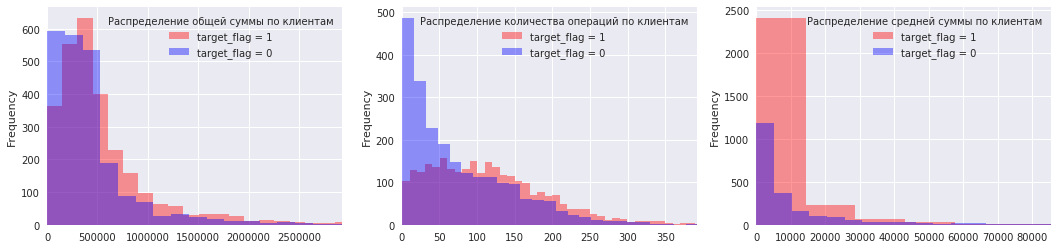

In [155]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
df1['sum'].plot.hist(bins=50, alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.hist(bins=50, alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.set_xlim(0,df0['sum'].max()/3)
ax1.legend(title='Распределение общей суммы по клиентам')

df1['count'].plot.hist(bins=50, alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.hist(bins=50, alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.set_xlim(0,df0['count'].max()/2)
ax2.legend(title='Распределение количества операций по клиентам')

df1['mean'].plot.hist(bins=50, alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.hist(bins=50, alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.set_xlim(0,df0['mean'].max()/3)
ax3.legend(title='Распределение средней суммы по клиентам')

Клиенты, которые ушли, были менее активны по количеству операций и с меньшей средней суммой

### Канал привлечения

In [156]:
df1 = df_train1.groupby(['channel_type'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['channel_type'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['channel_type'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['channel_type'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']
#df1 = df1.divide(df1_cli['nunique'], axis=0)
#df0 = df0.divide(df0_cli['nunique'], axis=0)

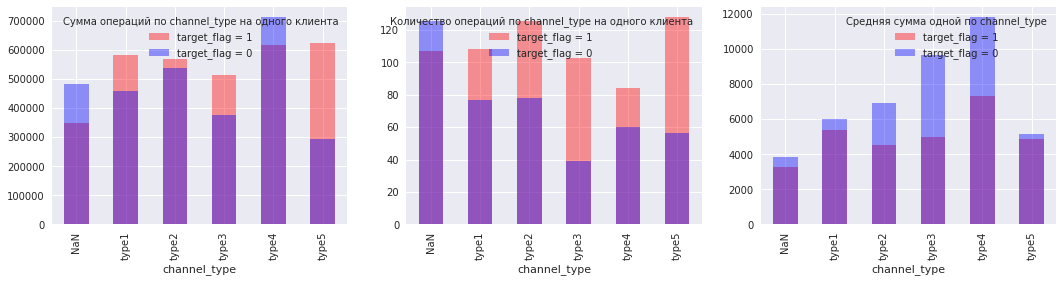

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма операций по channel_type на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по channel_type на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной по channel_type')

### MCC коды

In [158]:
df1 = df_train1.groupby(['MCC'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['MCC'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['MCC'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['MCC'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

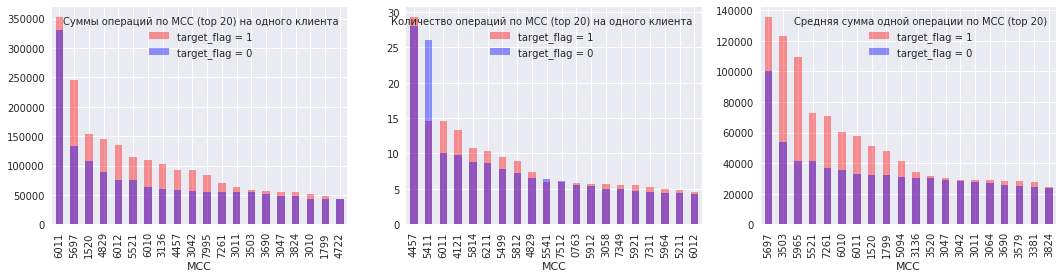

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1.nlargest(20, 'sum')['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0.nlargest(20, 'sum')['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по MCC (top 20) на одного клиента')

df1.nlargest(20, 'count')['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0.nlargest(20, 'count')['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по MCC (top 20) на одного клиента')

df1.nlargest(20, 'mean')['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0.nlargest(20, 'mean')['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции по MCC (top 20)')

По суммам операций клиенты больше всего просто снимали наличные (6011), по количеству операций больше всего платили в супермаркетах (5411)

### Группы MCC кодов

In [160]:
df1 = df_train1.groupby(['MCC_group'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['MCC_group'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['MCC_group'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['MCC_group'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

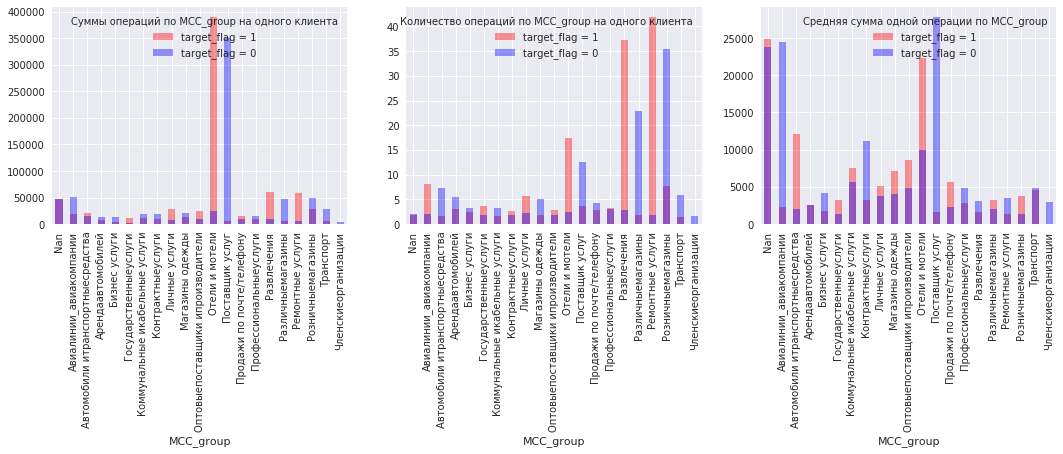

In [161]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по MCC_group на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по MCC_group на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции по MCC_group')

### Категории транзакций

In [162]:
df1 = df_train1.groupby(['trx_category'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['trx_category'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['trx_category'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['trx_category'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

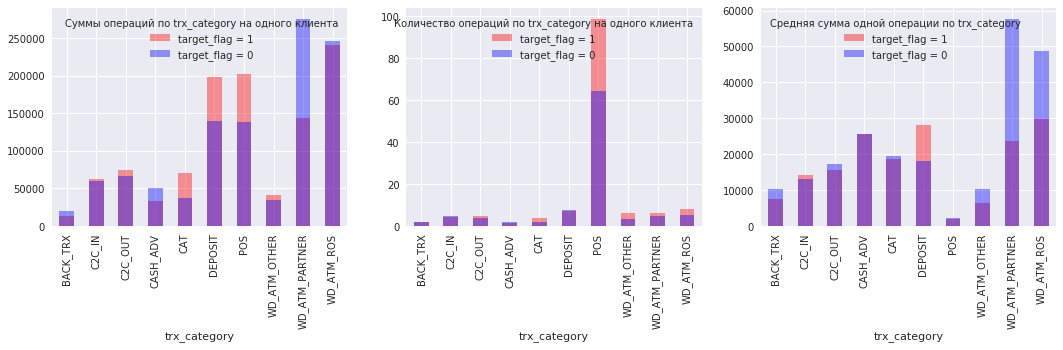

In [163]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по trx_category на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по trx_category на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции по trx_category')

Ожидаемо, клиенты, которые ушли, по средней сумме больше выводили денежные средства

### Дни недели

In [164]:
df1 = df_train1.groupby(['dayofweek'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['dayofweek'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['dayofweek'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['dayofweek'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']


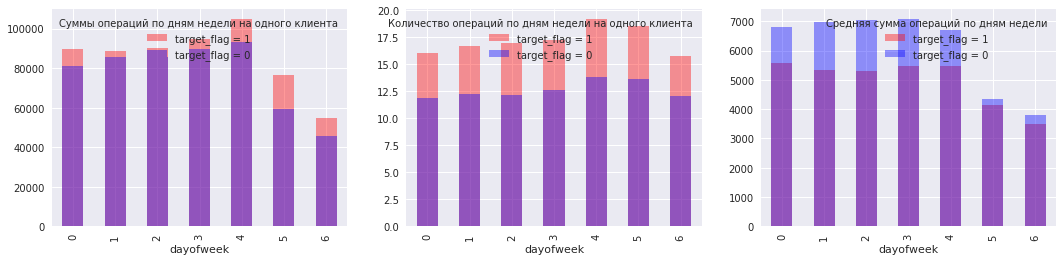

In [165]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по дням недели на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по дням недели на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма операций по дням недели')

Количество и сумма по операциям в пятницу больше, чем в остальные дни. Но странно, что средний размер суммы у клиентов, которые ушли, почему-то выше..

### Данные по периодам

In [166]:
df1 = df_train1.groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0.groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df1_cli = df_train1.groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

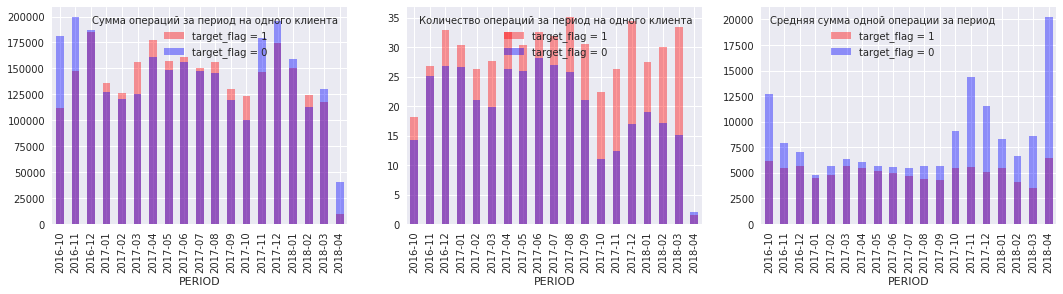

In [167]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма операций за период на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций за период на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции за период')

В первых начальных периодах активность клиентов обеих категорий примерно одинакова. Дальше, клиенты, которые ушли, былии меннее активны. Но средяя сумма операции у этих клиентов все равно выше. Видимо, к этой категории относятся более состоятельные клиенты

In [168]:
df1 = df_train1[df_train1['is_withdrawal']==True].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0[df_train0['is_withdrawal']==True].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df1_cli = df_train1[df_train1['is_withdrawal']==True].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df0_cli = df_train0[df_train0['is_withdrawal']==True].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

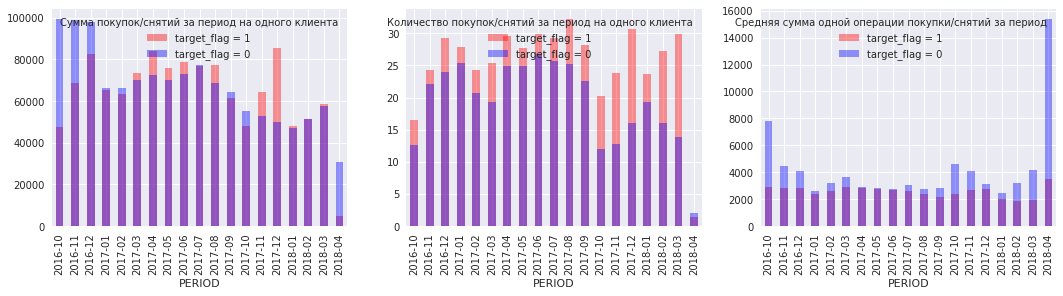

In [169]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма покупок/снятий за период на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество покупок/снятий за период на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции покупки/снятий за период')

In [170]:
df1 = df_train1[df_train1['is_withdrawal']==False].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0[df_train0['is_withdrawal']==False].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df1_cli = df_train1[df_train1['is_withdrawal']==False].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df0_cli = df_train0[df_train0['is_withdrawal']==False].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

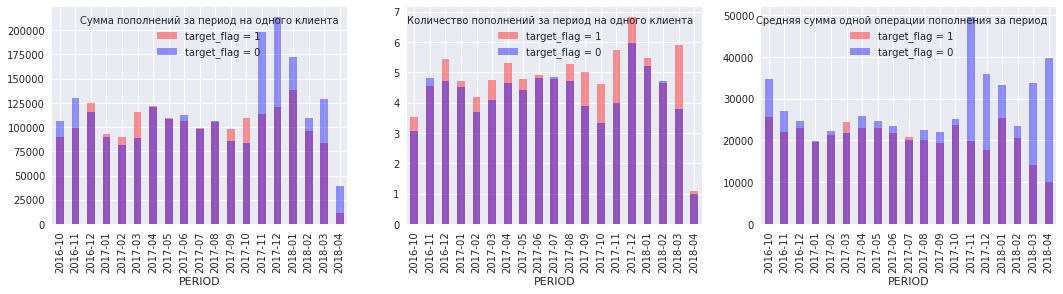

In [171]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма пополнений за период на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество пополнений за период на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции пополнения за период')

Активность пополнений всех клиентов во второй половине периодов снизилась. Средний размер пополнений у ушедших клиентов был выше. Скорее всего продукт был кредитной картой, эти клиенты делали пополнения перед закрытием

## Признаки

In [254]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend,is_withdrawal
0,2016-10,1290,5411,type2,810,2016-10-07,2465.00,POS,0,Розничныемагазины,RUB,1.0,1.0,2465.00,4,0,True
1,2016-10,7689,5921,type1,810,2016-10-07,119.78,POS,1,Различныемагазины,RUB,1.0,1.0,119.78,4,0,True
2,2016-10,7689,5411,type1,810,2016-10-07,2678.00,POS,1,Розничныемагазины,RUB,1.0,1.0,2678.00,4,0,True
3,2016-10,485,6011,type2,810,2016-10-07,3600.00,WD_ATM_PARTNER,0,Поставщик услуг,RUB,1.0,1.0,3600.00,4,0,True
4,2016-10,485,4121,type2,810,2016-10-07,242.00,POS,0,Транспорт,RUB,1.0,1.0,242.00,4,0,True


In [255]:
df.shape

(1008889, 17)

In [256]:
X_full = df.groupby(['cl_id', 'channel_type', 'is_test'])['amount_rub'].agg(['sum','count','mean']).sort_index()

In [257]:
X_full = X_full.reset_index().set_index('cl_id')

In [258]:
X_full.shape

(10217, 5)

In [260]:
X_full = pd.get_dummies(X_full)
X_full.head()

,is_test,sum,count,mean,channel_type_NaN,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
cl_id,,,,,,,,,,
0,0,64383.000000,5,12876.600000,1,0,0,0,0,0
1,0,327185.976007,104,3146.019000,1,0,0,0,0,0
2,1,328717.720000,199,1651.847839,1,0,0,0,0,0
3,1,270046.090000,96,2812.980104,1,0,0,0,0,0
4,1,351133.982477,158,2222.366978,1,0,0,0,0,0


In [261]:
df_temp = df.groupby(['cl_id', 'MCC'])['amount_rub'].agg(['sum']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.shape

(10217, 384)

In [262]:
df_temp.head()

,sum_0742,sum_0763,sum_0780,sum_1520,sum_1711,sum_1731,sum_1740,sum_1750,sum_1761,sum_1799,...,sum_8699,sum_8911,sum_8931,sum_8999,sum_9211,sum_9222,sum_9311,sum_9399,sum_9402,sum_9405
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7844.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7811.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='mcc')
X_full.shape

(10217, 394)

In [264]:
#X_full.isnull().values.any()

In [265]:
df_temp = df.groupby(['cl_id', 'currency'])['amount'].agg(['sum']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_032,sum_036,sum_044,sum_048,sum_051,sum_124,sum_144,sum_156,sum_170,sum_188,...,sum_944,sum_946,sum_949,sum_975,sum_977,sum_978,sum_980,sum_981,sum_985,sum_986
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,884.91,0.0,0.00,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,802.68,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,186.23,0.0,0.00,0.0,0.0


In [266]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='curr')
X_full.shape

(10217, 461)

In [267]:
#X_full.isnull().values.any()

In [268]:
df_temp = df.groupby(['cl_id', 'trx_category'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_BACK_TRX,sum_C2C_IN,sum_C2C_OUT,sum_CASH_ADV,sum_CAT,sum_DEPOSIT,sum_POS,sum_WD_ATM_OTHER,sum_WD_ATM_PARTNER,sum_WD_ATM_ROS,...,mean_BACK_TRX,mean_C2C_IN,mean_C2C_OUT,mean_CASH_ADV,mean_CAT,mean_DEPOSIT,mean_POS,mean_WD_ATM_OTHER,mean_WD_ATM_PARTNER,mean_WD_ATM_ROS
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,36562.0,0.0,0.0,20000.0,7821.000000,0.0,0.0,0.0,...,0.0,0.0,36562.0,0.0,0.0,20000.0,2607.000000,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,95000.0,182185.976007,0.0,0.0,50000.0,...,0.0,0.0,0.0,0.0,0.0,47500.0,1803.821545,0.0,0.000000,50000.000000
2,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.720000,0.0,78500.0,55400.0,...,2220.0,300.0,1000.0,0.0,0.0,0.0,1080.444114,0.0,7136.363636,6155.555556
3,0.0,75000.0,35000.0,0.0,0.0,0.0,115646.090000,9500.0,0.0,34900.0,...,0.0,37500.0,17500.0,0.0,0.0,0.0,1482.642179,2375.0,0.000000,3490.000000
4,0.0,0.0,1150.0,0.0,0.0,0.0,298183.982477,0.0,30500.0,21300.0,...,0.0,0.0,575.0,0.0,0.0,0.0,2042.356044,0.0,5083.333333,5325.000000


In [269]:
X_full = X_full.join(df_temp, how='left', on='cl_id')
X_full.shape

(10217, 491)

In [270]:
#X_full.isnull().values.any()

In [271]:
df_temp = df.groupby(['cl_id', 'MCC_group'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_Nan,sum_Авиалинии_авиакомпании,sum_Автомобили итранспортныесредства,sum_Арендаавтомобилей,sum_Бизнес услуги,sum_Государственныеуслуги,sum_Коммунальные икабельные услуги,sum_Контрактныеуслуги,sum_Личные услуги,sum_Магазины одежды,...,mean_Отели и мотели,mean_Поставщик услуг,mean_Продажи по почте/телефону,mean_Профессиональныеуслуги,mean_Развлечения,mean_Различныемагазины,mean_Ремонтные услуги,mean_Розничныемагазины,mean_Транспорт,mean_Членскиеорганизации
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,...,0.0,28281.000000,0.0,0.0,0.000000,767.000000,0.0,3527.000000,0.000000,0.0
1,0.0,0.0,0.00,0.0,2037.228,210.0,0.0,0.0,0.0,10586.019844,...,0.0,36455.344900,0.0,0.0,2031.613483,1861.809015,0.0,1500.711419,1752.182665,0.0
2,0.0,6000.0,307.90,0.0,7844.000,0.0,11429.0,0.0,15334.0,35165.000000,...,975.0,6008.695652,0.0,0.0,995.000000,858.360536,0.0,292.648889,695.542857,0.0
3,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,911.4,45053.730000,...,0.0,8577.777778,0.0,0.0,0.000000,998.258980,0.0,1098.174615,2163.333333,0.0
4,0.0,0.0,6007.94,0.0,8111.000,0.0,749.0,0.0,0.0,7072.500000,...,0.0,4412.500000,0.0,3000.0,3350.000000,858.079740,0.0,6753.349615,0.000000,0.0


In [272]:
X_full = X_full.join(df_temp, how='left', on='cl_id')
X_full.shape

(10217, 554)

In [273]:
#X_full.isnull().values.any()

In [274]:
df_temp = df.groupby(['cl_id', 'dayofweek'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_0,sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,count_0,count_1,count_2,...,count_4,count_5,count_6,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.00000,37329.000000,0.00000,20000.000000,0.000000,7054.000000,0.0000,0,2,0,...,0,2,0,0.000000,18664.500000,0.000000,20000.000000,0.000000,3527.000000,0.000000
1,23183.66944,71007.367213,8965.73065,13704.280704,20570.289743,82352.388557,107402.2497,20,20,16,...,10,15,7,1159.183472,3550.368361,560.358166,856.517544,2057.028974,5490.159237,15343.178529
2,44580.21000,82033.300000,39448.36000,44534.750000,58713.000000,32823.400000,26584.7000,32,41,29,...,37,15,8,1393.131562,2000.812195,1360.288276,1203.641892,1586.837838,2188.226667,3323.087500
3,46694.00000,18736.790000,30971.19000,46386.380000,82359.000000,30807.000000,14091.7300,17,14,16,...,15,9,8,2746.705882,1338.342143,1935.699375,2728.610588,5490.600000,3423.000000,1761.466250
4,21565.00000,28364.580000,6272.98000,27184.602477,151919.500000,84055.110000,31772.2100,17,8,12,...,28,49,22,1268.529412,3545.572500,522.748333,1235.663749,5425.696429,1715.410408,1444.191364


In [275]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='dayofweek')
X_full.shape

(10217, 575)

In [276]:
#X_full.isnull().values.any()

In [277]:
df_temp = df.groupby(['cl_id', 'is_weekend'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_0,sum_1,count_0,count_1,mean_0,mean_1
cl_id,,,,,,
0,57329.000000,7054.000000,3,2,19109.666667,3527.000000
1,137431.337750,189754.638257,82,22,1675.991924,8625.210830
2,269309.620000,59408.100000,176,23,1530.168295,2582.960870
3,225147.360000,44898.730000,79,17,2849.966582,2641.101765
4,235306.662477,115827.320000,87,71,2704.674281,1631.370704


In [278]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='weekend')
X_full.shape

(10217, 581)

In [279]:
#X_full.isnull().values.any()

In [280]:
df_temp = df.groupby(['cl_id', 'PERIOD'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_2016-10,sum_2016-11,sum_2016-12,sum_2017-01,sum_2017-02,sum_2017-03,sum_2017-04,sum_2017-05,sum_2017-06,sum_2017-07,...,mean_2017-07,mean_2017-08,mean_2017-09,mean_2017-10,mean_2017-11,mean_2017-12,mean_2018-01,mean_2018-02,mean_2018-03,mean_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,15904.00000,0.0,767.0,0.00,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,53930.26,...,4902.750909,543.928571,3857.422657,1262.00047,0.0,0.0,0.00,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,77439.16,95631.96,137492.8,18153.8,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1000.0,85964.94,113730.00,...,2369.375000,3650.060526,0.000000,0.00000,0.0,0.0,0.00,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,104.99,1580.436867,3001.420993,749.0


In [281]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period')
X_full.shape

(10217, 638)

In [282]:
#X_full.isnull().values.any()

In [283]:
df_temp = df[df['is_withdrawal']==True].groupby(['cl_id', 'PERIOD'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_2016-10,sum_2016-11,sum_2016-12,sum_2017-01,sum_2017-02,sum_2017-03,sum_2017-04,sum_2017-05,sum_2017-06,sum_2017-07,...,mean_2017-07,mean_2017-08,mean_2017-09,mean_2017-10,mean_2017-11,mean_2017-12,mean_2018-01,mean_2018-02,mean_2018-03,mean_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,3527.00000,0.0,767.0,0.00,0.00000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,3930.26,...,393.026000,543.928571,2402.670079,1262.00047,0.0,0.0,0.00,0.00000,0.000000,0.0
2,0.0,0.0,0.0,0.0,47239.16,65691.96,136492.8,18153.8,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00,0.00000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,49964.94,44330.00,...,1081.219512,1334.446875,0.000000,0.00000,0.0,0.0,0.00,0.00000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,104.99,1508.45325,2959.339035,749.0


In [284]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period_out')
X_full.shape

(10217, 695)

In [285]:
#X_full.isnull().values.any()

In [286]:
df_temp = df[df['is_withdrawal']==False].groupby(['cl_id', 'PERIOD'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_2016-10,sum_2016-11,sum_2016-12,sum_2017-01,sum_2017-02,sum_2017-03,sum_2017-04,sum_2017-05,sum_2017-06,sum_2017-07,...,mean_2017-07,mean_2017-08,mean_2017-09,mean_2017-10,mean_2017-11,mean_2017-12,mean_2018-01,mean_2018-02,mean_2018-03,mean_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,28281.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,...,50000.000000,0.0,47500.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,30200.0,29940.0,1000.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,36000.0,69400.0,...,9914.285714,16000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3500.0,3983.333333,0.0


In [287]:
#df_temp.isnull().values.any()

In [288]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period_in')
X_full.shape

(10217, 752)

In [289]:
X_full.fillna(0, inplace=True)
X_full.isnull().values.any()

False

## Отбор признаков

In [297]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, SVC

In [295]:
X_train = X_full[X_full['is_test']==0].copy()
X_pred = X_full[X_full['is_test']==1].copy()
y = pd.Series(y['target_flag'])
X_train.drop(columns=['is_test'], inplace=True)
X_pred.drop(columns=['is_test'], inplace=True)
X_full.drop(columns=['is_test'], inplace=True)
X_train.shape, X_pred.shape, y.shape

/home/max/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


((5000, 751), (5217, 751), (5000, 1))

In [346]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_train, y, test_size=0.30, stratify=y, random_state=42)

### PCA

Посмотрим, сколько признаков из 752 останется после применения PCA трансформации с сохранением 99% дисперсии

In [300]:
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.99))
])

X_pca = pca_pipe.fit_transform(X_train)
X_pca.shape

(5000, 525)

Посмотрим, сколько признаков из 752 останется после применения PCA трансформации с сохранением 95% дисперсии

In [301]:
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.95))
])

X_pca = pca_pipe.fit_transform(X_train)
X_pca.shape

(5000, 429)

In [308]:
pca_pipe.named_steps['select'].explained_variance_ratio_[:50]

array([0.03106767, 0.02714321, 0.02096744, 0.01857548, 0.0161585 ,
       0.01532126, 0.01227019, 0.01049945, 0.00968344, 0.00848629,
       0.00781074, 0.00747184, 0.00705063, 0.00683954, 0.00633236,
       0.0061198 , 0.0059776 , 0.00589871, 0.00567418, 0.00558193,
       0.00539845, 0.00531877, 0.00522807, 0.00512912, 0.00504531,
       0.00495138, 0.00485467, 0.00479135, 0.00469986, 0.00465006,
       0.00460989, 0.00450797, 0.00443834, 0.004376  , 0.00436327,
       0.00435261, 0.00424861, 0.00415951, 0.00412735, 0.00403375,
       0.00402435, 0.00393693, 0.00387901, 0.00386813, 0.00379897,
       0.00376544, 0.00373798, 0.00366701, 0.00362941, 0.00358195])

In [312]:
pca_pipe.named_steps['select'].components_[:50, :]

array([[ 0.16137904,  0.15603434,  0.01544947, ...,  0.0054129 ,
         0.00754894,  0.00095296],
       [ 0.13921807, -0.13417366,  0.1653222 , ...,  0.00982128,
         0.02668028,  0.00470128],
       [-0.03397044, -0.06395249,  0.01327496, ...,  0.05083218,
         0.04110668,  0.02326379],
       ...,
       [ 0.00249217, -0.00042115, -0.02329982, ..., -0.02955205,
        -0.04388672, -0.03435163],
       [-0.0076897 ,  0.00379237,  0.0022943 , ...,  0.00341033,
        -0.00406829,  0.01257775],
       [-0.00802442, -0.00453334,  0.00289126, ...,  0.03945802,
         0.01882356,  0.04905355]])

### SelectFomModel

In [317]:
X_train.head()

,sum,count,mean,channel_type_NaN,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,sum_0742,...,mean_2017-07period_in,mean_2017-08period_in,mean_2017-09period_in,mean_2017-10period_in,mean_2017-11period_in,mean_2017-12period_in,mean_2018-01period_in,mean_2018-02period_in,mean_2018-03period_in,mean_2018-04period_in
cl_id,,,,,,,,,,,,,,,,,,,,,
0,6.438300e+04,5,12876.600000,1,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,28281.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.271860e+05,104,3146.019000,1,0,0,0,0,0,0.0,...,50000.000000,0.000000,47500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.482042e+05,142,3860.592809,1,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8.493151e+05,39,21777.310000,1,0,0,0,0,0,0.0,...,75000.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.124344e+06,463,2428.388747,1,0,0,0,0,0,0.0,...,1766.071429,17286.414167,3879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [324]:
y.shape

(5000,)

In [325]:
select_rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectFromModel(estimator=RandomForestClassifier()))
])

X_from_rf = select_rf_pipe.fit(X_train, y).transform(X_train)
X_from_rf.shape

(5000, 217)

Важность признаков (top 40 из 217), отобранных с помощью модели RandomForestClassifier

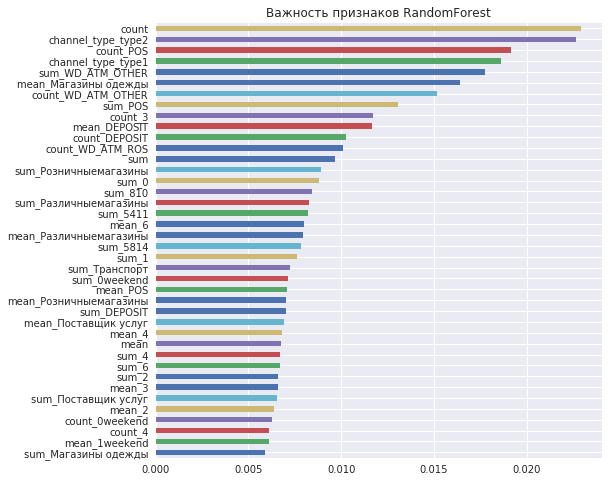

In [332]:
imp = pd.Series(select_rf_pipe.named_steps['select'].estimator_.feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False).head(40)[::-1].plot(kind='barh', title='Важность признаков RandomForest',  figsize=(8,8))

In [336]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectFromModel(LogisticRegression(penalty='l1')))
])


lasso_pipe.fit(X_train, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None))])

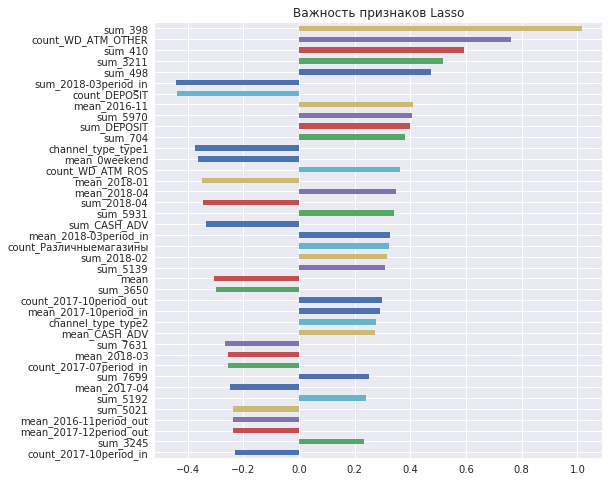

In [343]:
imp_lasso = pd.Series(lasso_pipe.named_steps['select'].estimator_.coef_[0], index=X_train.columns)
imp_lasso = imp_lasso.reindex(imp_lasso.abs().sort_values(ascending=False).index)
imp_lasso.head(40)[::-1].plot(kind='barh', title='Важность признаков Lasso',  figsize=(8,8))

## Модели

In [348]:
clf_line1 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])


clf_line2 = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.99)),
    ('clf', LogisticRegression())
])

clf_line3 = Pipeline([
    ('scaler', StandardScaler()),
    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', LogisticRegression())
])




#cross_val_score(clf_line1, X_train_l, y_train_l, cv=5, scoring='roc_auc')


In [350]:
print('Линейная модель:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line1, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель:
roc_auc на cv: 0.7140102940745436


In [351]:
print('Линейная модель c PCA:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line2, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель c PCA:
roc_auc на cv: 0.7156536443452733


In [352]:
print('Линейная модель c PCA и отбором признаков:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line3, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель c PCA и отбором признаков:
roc_auc на cv: 0.7314246750278033


In [353]:
clf_svc1 = Pipeline([
    ('scaler', StandardScaler()),
    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', LinearSVC())
])

clf_svc2 = Pipeline([
    ('scaler', StandardScaler()),
    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', SVC(kernel='rbf'))
])

In [354]:
print('Линейный SVC:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_svc1, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейный SVC:
roc_auc на cv: 0.7246439588537296


In [355]:
print('Нелинейный SVC:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_svc1, X_train, y, cv=5, scoring='roc_auc').mean()))

Нелинейный SVC:
roc_auc на cv: 0.7351460601219957


## Предсказание

Лучшей моделью с параметрами по умолчанию оказался нелинейный SVM с ядром RBF. Точность можно было бы улучшить настройкой параметров на GridSearch. Времени на это не осталось. Делаем предсказание, как есть.

In [356]:
clf_svc2.fit(X_train, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select1', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('select2', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [357]:
y_pred = clf_svc2.predict(X_pred)

In [360]:
y_pred = pd.Series(y_pred, index=X_pred.index)

In [363]:
y_pred.value_counts()

1    2761
0    2456
dtype: int64

In [367]:
y_pred.to_csv('predictions.csv', sep=',', header=True, index_label=['_ID_', '_VAL_'])